<a href="https://colab.research.google.com/github/jasonyang429/CNN-for-CIFAR100/blob/main/Cifar100_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### CIFAR100 Image Classification
This is an example of CIFAR 100 Image Classification Task using fine classes. I have used 2 different models where the first one is the model that I have personally designed, and the second model is using transfer leraning with ResNet50 architecture. 

For my own model, I have reached ~70% Training accuracy, ~55% validation accuracy after 120 epochs, where each epochs took about 38 seconds, running on GPU.

For the transfer learning model using ResNet50 where I got insights from another person [(link here)](https://github.com/balajikulkarni/The-one-with-Deep-Learning/blob/master/TransferLearning/TransferLearning.ipynb) have reached a ~65% training accuracy and ~45% validation accuracy. This model took me 1.5 hours just for 15 epochs, where each epochs took about 420 seconds.

The evaluation task I only carried out on the transfer learning model, where it reached about 70% accuracy.


Firstly, import all neccessary modules.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.datasets import cifar100
print(tf.__version__)

2.3.0


Here, split the train and test sets, and convert the labels into one hot encoded vectors.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

y_train_oh = tf.keras.utils.to_categorical(y_train)
y_test_oh = tf.keras.utils.to_categorical(y_test)

split = int(0.8 * len(x_test))
x_val = x_test[split:]
y_val_oh = y_test_oh[split:]
x_test = x_test[:split]
y_test_oh = y_test_oh[:split]

print("Training set size:", len(x_train))
print("Validation set size:", len(x_val))
print("Test set size:", len(x_test))
print("Number of classes:", len(np.unique(y_train)))
print("Input shape:", x_train.shape)

169009152/169001437 [==============================] - 4s 0us/step
Training set size: 50000
Validation set size: 2000
Test set size: 8000
Number of classes: 100
Input shape: (50000, 32, 32, 3)


Here, I visualized random images from the training sets.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: This function is deprecated. Please call randint(0, 7999 + 1) instead


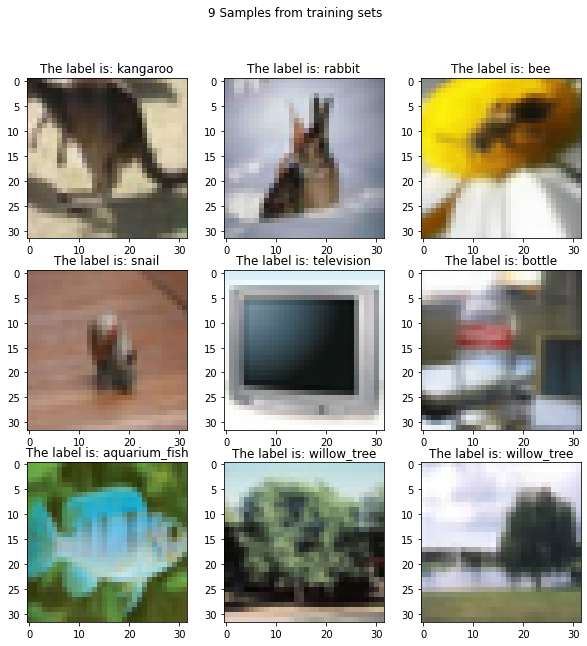

In [3]:
def label_name(label):
  labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm']

  return labels[label]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    random_img = np.random.random_integers(0, split-1)
    plt.sca(ax)
    plt.imshow(x_train[random_img], cmap=plt.get_cmap())
    plt.title('The label is: {}'.format(label_name(int(y_train[random_img]))))

plt.suptitle('9 Samples from training sets')
plt.show()

Here, I have used a ResNet50 architecture for transfer learning. I have also included my own architecture in the comments below, with the optimizers, loss function and learning rate respectively. 

Also, I have did some image augmentation for the training sets, for better generalization purpose.

From [here](https://github.com/balajikulkarni/The-one-with-Deep-Learning/blob/master/TransferLearning/TransferLearning.ipynb), the reason for UpSampling2D is to convert the CIFAR100 images' shapes from (32, 32, 3) into (224, 224, 3) which is same as the ImageNet images' shapes.

The reason for setting BatchNormalization layer to trainable could be referred [here](https://github.com/keras-team/keras/pull/9965)

In [4]:
  
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

resnet_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in resnet_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False

model = tf.keras.Sequential([
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.UpSampling2D(),
        tf.keras.layers.UpSampling2D(),
        resnet_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer='l2'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation='softmax')
])

datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(x_train)





# MODEL - 1
# ~70% train accuracy and ~55% val accuracy after 120 epochs, each epochs 38 seconds
# model.compile(optimizer=tf.keras.optimizers.SGD(0.003, momentum=0.9, nesterov=True), loss='categorical_crossentropy', 
#               metrics=['accuracy'])
# model = tf.keras.Sequential([
#           tf.keras.layers.Conv2D(256, (3,3), 1, input_shape=(32,32,3)),
#           tf.keras.layers.MaxPooling2D(2,2),
#           tf.keras.layers.Dropout(0.1),
#           tf.keras.layers.Conv2D(512, (3,3), 1, activation='relu'),
#           tf.keras.layers.MaxPooling2D(2,2),
#           tf.keras.layers.Dropout(0.2),
#           tf.keras.layers.Conv2D(1024, (3,3), 1, activation='relu'),
#           tf.keras.layers.MaxPooling2D(2,2),
#           tf.keras.layers.GlobalAveragePooling2D(),
#           tf.keras.layers.Flatten(),
#           tf.keras.layers.Dense(1024, activation='relu'),
#           tf.keras.layers.Dropout(0.2),
#           tf.keras.layers.Dense(512, activation='relu'),
#           tf.keras.layers.Dropout(0.15),
#           tf.keras.layers.Dense(256, activation='relu'),
#           tf.keras.layers.Dropout(0.1),
#           tf.keras.layers.Dense(128, activation='relu'),
#           tf.keras.layers.Dropout(0.05),
#           tf.keras.layers.Dense(64, activation='relu'),
#           tf.keras.layers.Dense(100, activation='softmax')
#   ])



94773248/94765736 [==============================] - 1s 0us/step


Compiling the model, and the time taken for each epochs is about 420 seconds, even on GPU.

In [5]:
BATCH_SIZE = 64
STEPS_PER_EPOCH = x_train.shape[0]//BATCH_SIZE
VALID_STEPS = x_val.shape[0]//BATCH_SIZE

model.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(datagen.flow(x_train, y_train_oh, batch_size=BATCH_SIZE),
                     epochs=15, steps_per_epoch=STEPS_PER_EPOCH,
                    verbose=2, validation_data=(x_val, y_val_oh))

Epoch 1/15
781/781 - 461s - loss: 3.8254 - accuracy: 0.3372 - val_loss: 3.1965 - val_accuracy: 0.3280
Epoch 2/15
781/781 - 460s - loss: 2.2928 - accuracy: 0.5127 - val_loss: 3.0836 - val_accuracy: 0.3630
Epoch 3/15
781/781 - 460s - loss: 2.0813 - accuracy: 0.5501 - val_loss: 3.6472 - val_accuracy: 0.2905
Epoch 4/15
781/781 - 460s - loss: 1.9568 - accuracy: 0.5785 - val_loss: 2.7290 - val_accuracy: 0.4300
Epoch 5/15
781/781 - 460s - loss: 1.8787 - accuracy: 0.5928 - val_loss: 2.7846 - val_accuracy: 0.4070
Epoch 6/15
781/781 - 460s - loss: 1.8170 - accuracy: 0.6055 - val_loss: 2.9505 - val_accuracy: 0.3845
Epoch 7/15
781/781 - 460s - loss: 1.7781 - accuracy: 0.6147 - val_loss: 2.4809 - val_accuracy: 0.4695
Epoch 8/15
781/781 - 460s - loss: 1.7338 - accuracy: 0.6198 - val_loss: 2.5656 - val_accuracy: 0.4495
Epoch 9/15
781/781 - 460s - loss: 1.7016 - accuracy: 0.6286 - val_loss: 2.6500 - val_accuracy: 0.4385
Epoch 10/15
781/781 - 460s - loss: 1.6821 - accuracy: 0.6296 - val_loss: 2.5329 - 

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d (UpSampling2D) (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, None)  0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

Visualizing the training and validation accuracy here, where the validation accuracy seems to be fluctuating. This could be further resolved by


*   Adding more regularization
*   Decreasing the model complexity, which is not ideal for using transfer learning



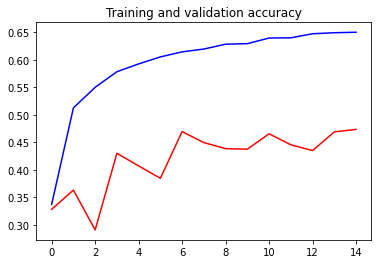

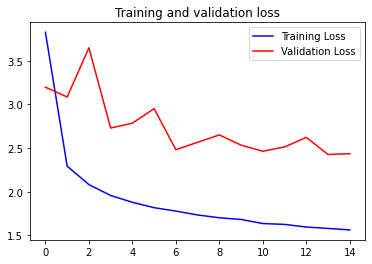

In [7]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Here, the final prediction result, which are 71% accuracy.

In [8]:
model.evaluate(x_test, y_test_oh)

250/250 [==============================] - 28s 111ms/step - loss: 1.3390 - accuracy: 0.7107


[1.339043378829956, 0.7107499837875366]